In [1]:
import subprocess

print(subprocess.check_output(["git", "-C", "/Users/lgrcia/code/nuance", "rev-parse", "HEAD"]))

b'0de493313678da42ab4c666db03fa1038380b27c\n'


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import numpy as np
from nuance import Nuance
from tinygp import kernels, GaussianProcess

df = pd.read_csv("/Users/lgrcia/Downloads/data_toi540/P1.4736842105263157_R2.08_1411.395447636109.csv")
time, flux, error = df.values.T
t_0 = time[0]
time -= t_0

/Users/lgrcia/code/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


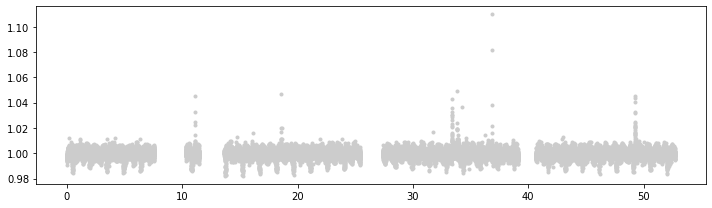

In [3]:
plt.figure(None, (10, 3))
plt.plot(time, flux, ".", c="0.8")
plt.tight_layout()

# Design matrix

In [4]:
X = time**np.arange(0, 3)[:, None]
X[1::] -= X[1::].mean(1)[:, None]
X[1::] /= X[1::].std(1)[:, None]

# GP

In [5]:
from tinygp import kernels, GaussianProcess
import yaml

params = yaml.full_load(open("../data/gp.yaml", "r"))

kernel = kernels.quasisep.SHO(
    omega=params["omega"], 
    quality=params["quality"], 
    sigma=params["sigma"]
) 
    
gp = GaussianProcess(kernel, time, diag=params["jitter"]**2, mean=1.)

# Sigclip

In [6]:
import jax

def mu(self, mask=None):
    if mask is None:
        mask = mask = np.ones_like(self.x).astype(bool)

    masked_x = self.time[mask]
    masked_y = self.flux[mask]
    masked_X = self.X[:, mask]
    
    @jax.jit
    def _mu():
        gp = self.gp
        _, w, _ = self.eval_m(np.zeros_like(self.time))
        w = w[0:-1]
        cond_gp = gp.condition(self.flux - w@self.X, self.time).gp
        return cond_gp.loc + w@self.X

    return _mu()

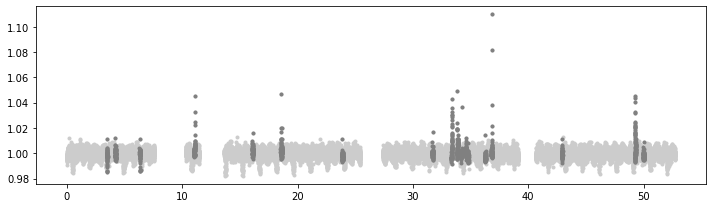

In [7]:
nu = Nuance(time, flux, kernel=kernel, error=error, X=X)

mask = np.ones_like(time).astype(bool)
mask_down = np.ones_like(time).astype(bool)
window = 30

plt.figure(None, (10, 3))
plt.plot(time, flux, ".", c="0.8")

for i in range(3):
    if i == 0:
        m = np.mean(flux)
    else:
        m = mu(nu, mask)
    #plt.plot(m)
    r = (flux - m)
    mask_up = np.array(r < np.std(r[mask])*4)
    #mask_down = np.array(r > - np.std(r[mask])*1.5)

    # mask around flares
    ups = np.flatnonzero(~mask_up)
    if len(ups) > 0:
        mask_up[np.hstack([np.arange(max(u-window, 0), min(u+window, len(nu.time))) for u in ups])] = False
    mask = np.logical_and(mask_up, mask_down)

plt.plot(time[~mask], flux[~mask], ".", c="0.5")
plt.tight_layout()

In [8]:
import numpy as np
from scipy.signal import welch

def estimate_red_noise(signal, fs):
    f, Pxx_den = welch(signal, fs, nperseg=1024, scaling='density')
    Pxx_den = 10*np.log10(Pxx_den)
    Pxx_den = Pxx_den[f>0]
    f = f[f>0]
    slope, _ = np.polyfit(np.log10(f), Pxx_den, 1)
    return slope

# Linear search

In [9]:
from nuance import Nuance
from tinygp import kernels, GaussianProcess

nu = Nuance(time[mask], flux[mask], error[mask], kernel=kernel, X=X[:, mask])

t0s = time.copy()
Ds = np.linspace(0.01, 0.1, 10)
linear = nu.linear_search(t0s, Ds)

  0%|          | 0/31564 [00:00<?, ?it/s]

# Periodic search 1

In [10]:
periods = np.linspace(.9, 5., 5000)
search = nu.periodic_search(periods)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
def binn(x, y, n):
    N = int(len(x)/n)
    ns = np.histogram(x, N)[0]
    bx = np.histogram(x, N, weights=x)[0]/ns
    by = np.histogram(x, N, weights=y)[0]/ns
    return bx, by

(-0.03867278263900716, 0.03867278263900716)

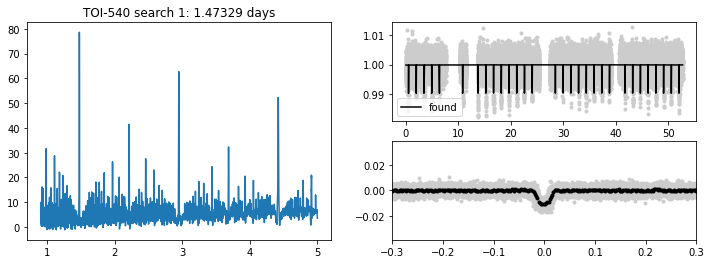

In [12]:
from nuance.utils import phase

plt.figure(None, (12, 4))
t0, D, P = search.best

plt.subplot(2, 2, (1, 3))
plt.plot(*search.periodogram())
plt.title(f"TOI-540 search 1: {P:.5f} days")

mean, astro, noise = nu.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu.time, nu.flux, ".", c="0.8")
plt.plot(nu.time, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu.models(t0, D, P)
phi = phase(nu.time, t0, P)
detrended = nu.flux - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

# Search 2

In [13]:
nu2 = nu.mask(t0, D, P)
search2 = nu2.periodic_search(periods)

  0%|          | 0/5000 [00:00<?, ?it/s]

(-0.00541145215435176, 0.00541145215435176)

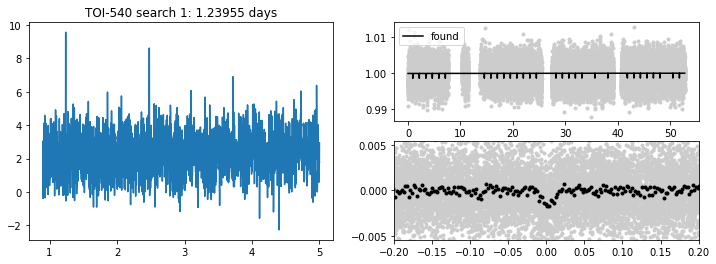

In [15]:
from nuance.utils import phase

plt.figure(None, (12, 4))
t0, D, P = search2.best

plt.subplot(2, 2, (1, 3))
plt.plot(*search2.periodogram())
plt.title(f"TOI-540 search 1: {P:.5f} days")

mean, astro, noise = nu2.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu2.time, nu2.flux, ".", c="0.8")
plt.plot(nu2.time, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu2.models(t0, D, P)
phi = phase(nu2.time, t0, P)
detrended = nu2.flux - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))